In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle
import shap
import joblib
from statannot.statannot import add_stat_annotation
from lib.data_load_utils import load_CULPRIT_data, get_data_from_features
from lib.experiment_definitions import get_features
from sklearn.calibration import calibration_curve


SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Models AUC

FileNotFoundError: [Errno 2] No such file or directory: '/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/full_model/Full_predictions.csv'

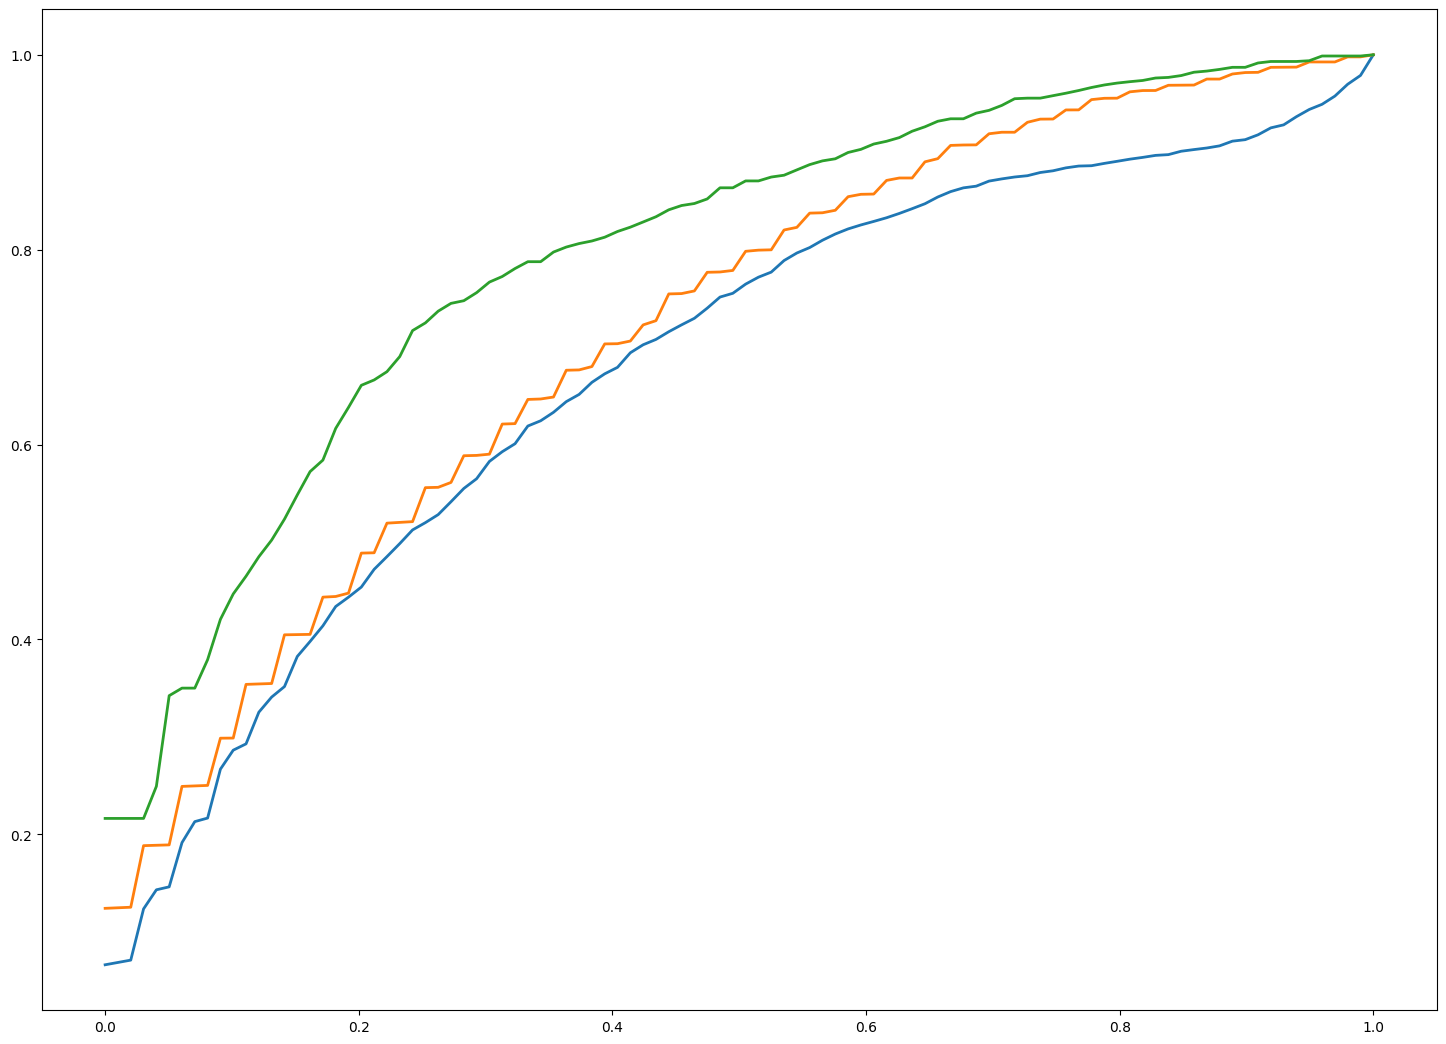

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd

root_dir_scores = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/predictions/v2/"
root_dir_admission = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/admission_model/"
root_dir_full = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/full_model/"

num_folds = 100
method_names = [["SAPS",root_dir_scores], 
                ["Admission",root_dir_admission], 
                ["CLIP",root_dir_scores],
                ["Full",root_dir_full]]

all_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(18, 13))

for method_name, root_dir in method_names:
    y_pred_all = pd.read_csv(root_dir+method_name+"_predictions.csv", index_col=0)
    y_true_all = pd.read_csv(root_dir+"y_true_"+method_name+".csv", index_col=0)
    # Initialize arrays to store accumulated TPR and FPR values
    mean_tpr = 0
    if method_name == "Admission":
        y_pred_all = y_pred_all.T
        y_true_all = y_true_all.T
    # Iterate through the folds for the current method
    for fold in y_pred_all.columns:
        y_pred = y_pred_all.loc[:,fold]
        y_pred.dropna(inplace=True)
        if method_name == "Admission":
            y_true = y_true_all.loc[:,(fold)]
        else:
            y_true = y_true_all.loc[:,str(fold)]
        y_true.dropna(inplace=True)

        # Calculate ROC curve for the current fold
        fpr, tpr, _ = roc_curve(y_true, y_pred)

        # Interpolate the TPR values to match the all_fpr values
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    # Calculate the mean TPR across all folds for the current method
    mean_tpr /= num_folds

    # Calculate the AUC for the average ROC curve of the current method
    mean_auc = auc(all_fpr, mean_tpr)
    # Plot the average ROC curve for the current method
    plt.plot(all_fpr, mean_tpr, lw=2, label=f'{method_name} (AUC = {mean_auc:.2f})')


# Plot the chance level line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance Level')

# Add labels and legend
# plt.title('Average ROC Curve across Folds')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(["SAPS II", "Admission Model", "CLIP", "Full Model"],loc='lower right')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Show the plot
plt.show()

# Full model calibration

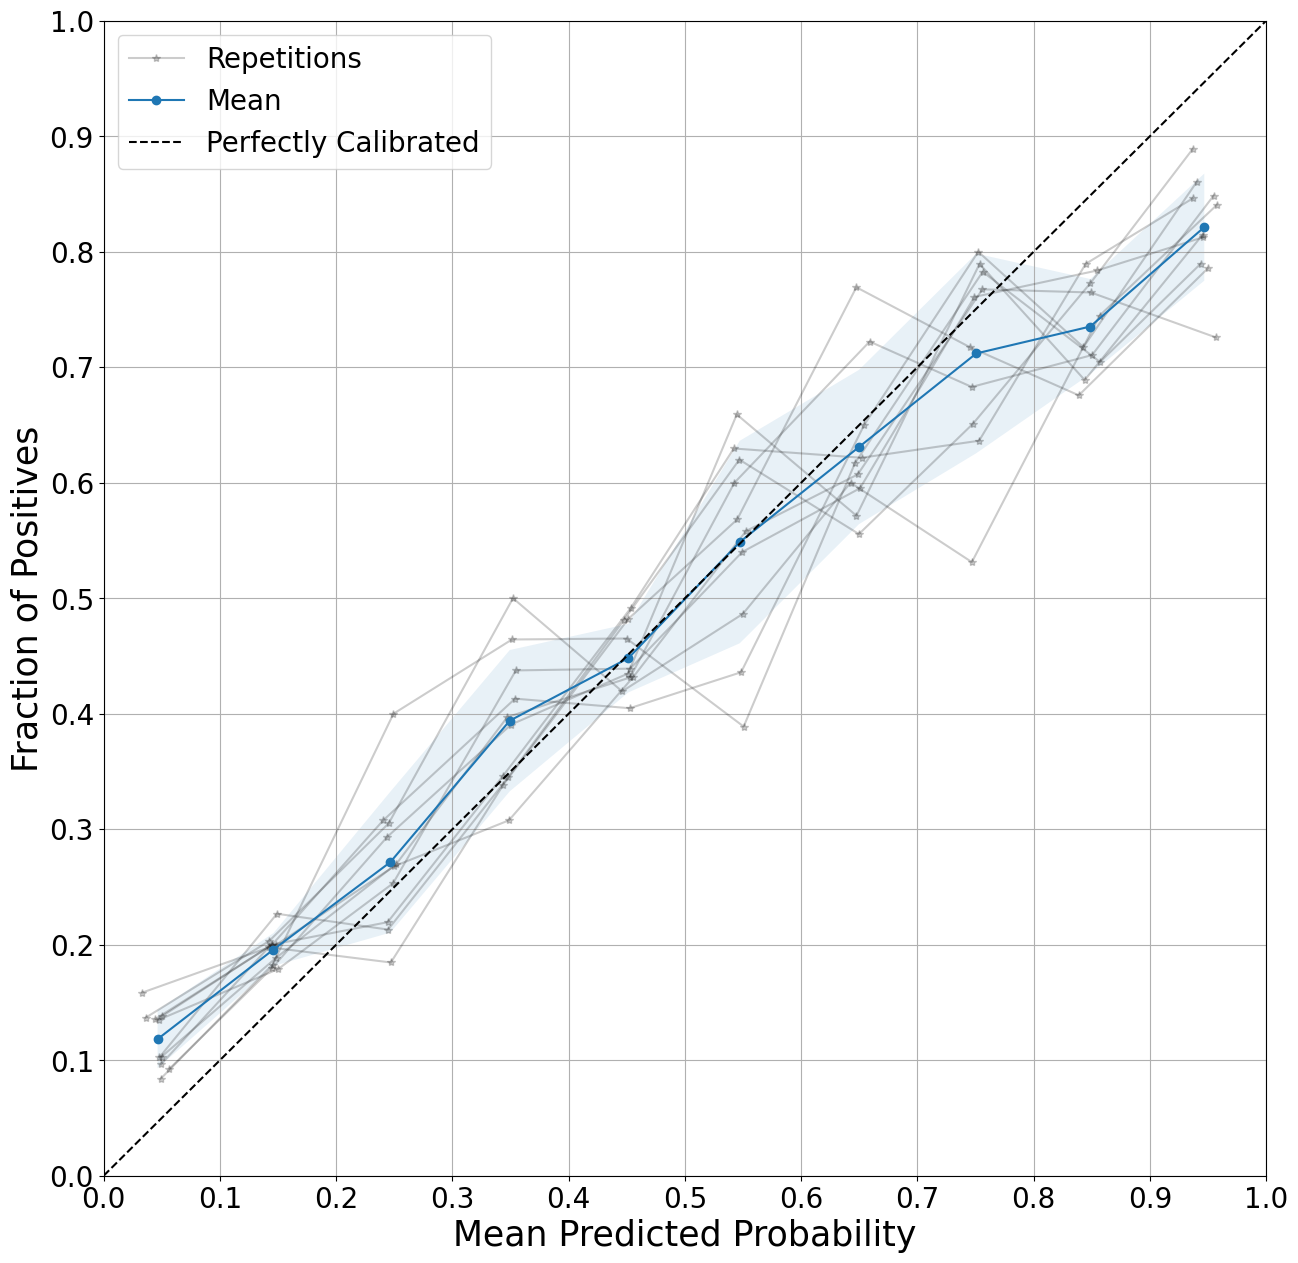

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/full_model/"

y_true = pd.read_csv(data_dir +"y_true_Full.csv", index_col=0)
y_pred = pd.read_csv(data_dir +"Full_predictions.csv", index_col=0)
import pandas as pd
import numpy as np

# Create a new DataFrame with the first 10 columns for each group
reshape_true = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_true.iloc[:,column]])

    reshape_true = pd.concat([reshape_true, new_col], axis=1)

reshape_true = reshape_true.dropna()
# Display the new DataFrame

# Create a new DataFrame with the first 10 columns for each group
reshape_pred = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_pred.iloc[:,column]])

    reshape_pred = pd.concat([reshape_pred, new_col], axis=1)

reshape_pred = reshape_pred.dropna()

df_fraction = pd.DataFrame()
df_mean_predicted = pd.DataFrame()

fig, ax = plt.subplots(1, 1, figsize=[15, 15])
for fold in range(reshape_pred.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        reshape_true.iloc[:, fold], reshape_pred.iloc[:, fold], n_bins=10, strategy='uniform'
    )
    df_fraction[fold] = fraction_of_positives
    df_mean_predicted[fold] = mean_predicted_value
    if fold == 0:
        plt.plot(mean_predicted_value, fraction_of_positives, label='Repetitions', marker='*', alpha=0.2, color="black")

    else:
        plt.plot(mean_predicted_value, fraction_of_positives,  marker='*', alpha=0.2, color="black")

plt.plot(df_mean_predicted.mean(axis=1), df_fraction.mean(axis=1), label='Mean', marker='o')
lim = [0,1]
# Plot the diagonal line for perfect calibration
plt.plot(lim, lim, linestyle='--', color='black', label='Perfectly Calibrated')
ax.fill_between(df_mean_predicted.mean(axis=1), df_fraction.mean(axis=1)-df_fraction.std(axis=1),
                df_fraction.mean(axis=1)+df_fraction.std(axis=1) ,alpha=0.1)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.xlim(lim)
plt.ylim(lim)
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid()
plt.show()

# Admission Calibration

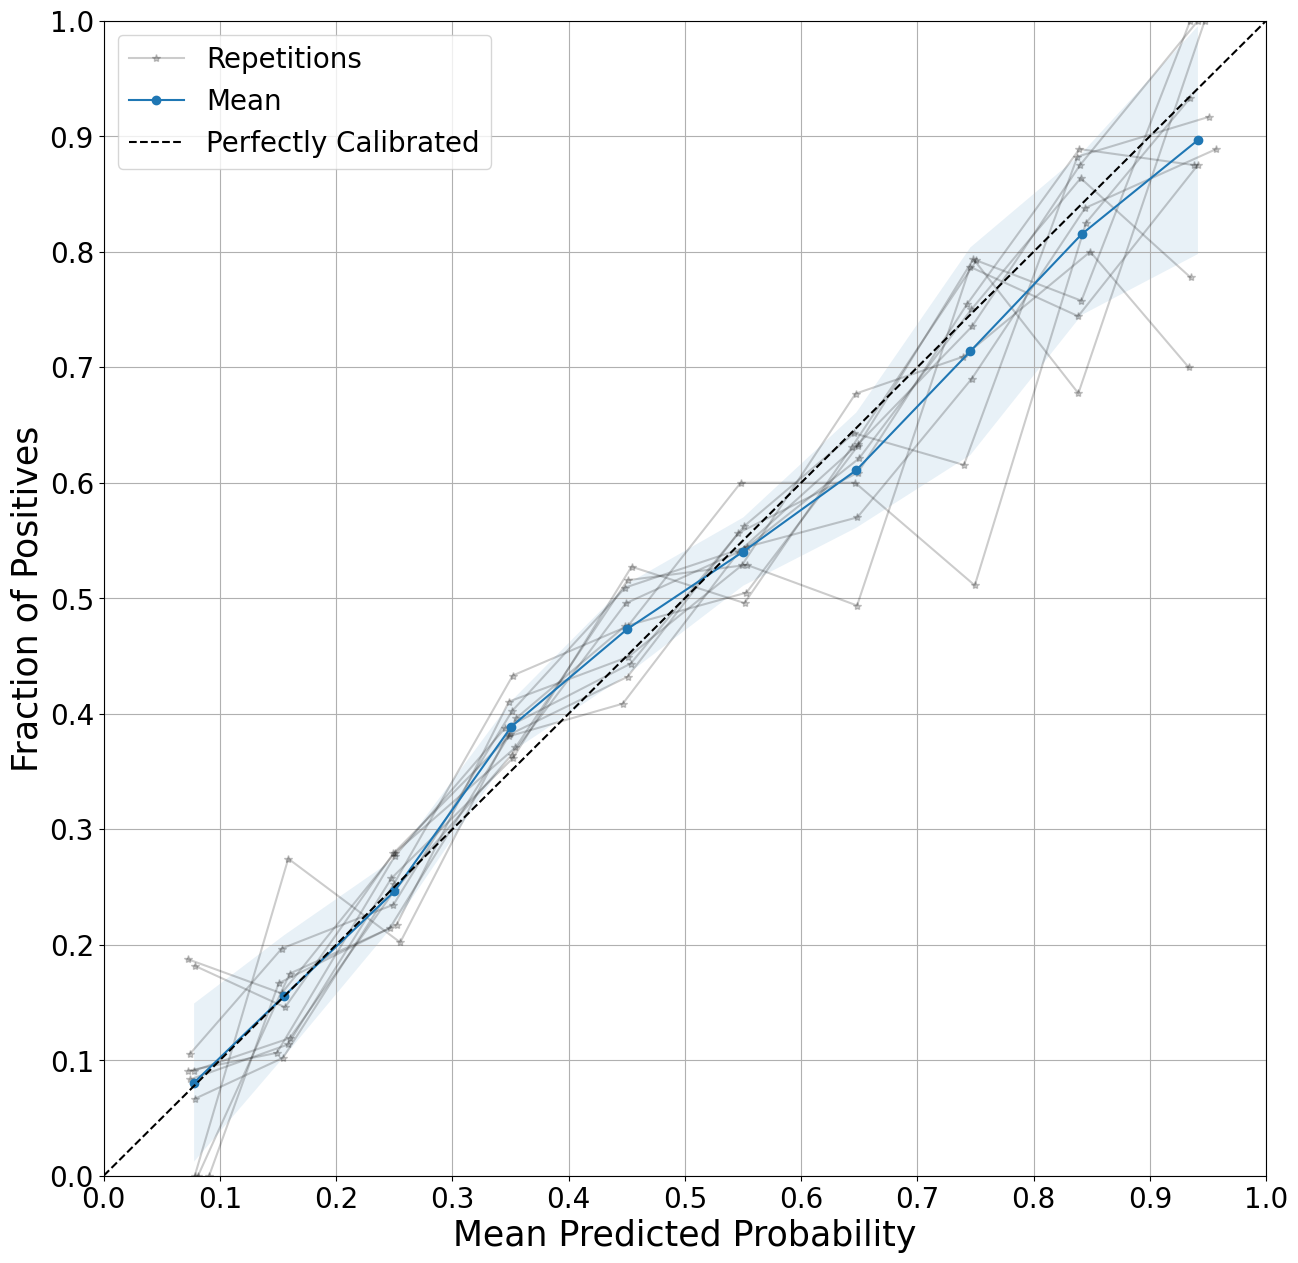

range(0, 1, 10)

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/admission_model/"

y_true = pd.read_csv(data_dir +"y_true_Admission.csv", index_col=0)
y_true = y_true.T
y_pred = pd.read_csv(data_dir +"Admission_predictions.csv", index_col=0)
y_pred = y_pred.T
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np

# Create a new DataFrame with the first 10 columns for each group
reshape_true = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_true.iloc[:,column]])

    reshape_true = pd.concat([reshape_true, new_col], axis=1)

reshape_true = reshape_true.dropna()
# Display the new DataFrame

# Create a new DataFrame with the first 10 columns for each group
reshape_pred = pd.DataFrame()

for fold_id in range(10):
    # print(fold_id)
    new_col = pd.DataFrame()
    fold_id = fold_id*10
    for repetition in range(10):

        column = fold_id + repetition
        new_col = pd.concat([new_col, y_pred.iloc[:,column]])

    reshape_pred = pd.concat([reshape_pred, new_col], axis=1)

reshape_pred = reshape_pred.dropna()

df_fraction = pd.DataFrame()
df_mean_predicted = pd.DataFrame()

fig, ax = plt.subplots(1, 1, figsize=[15, 15])
for fold in range(reshape_pred.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        reshape_true.iloc[:, fold], reshape_pred.iloc[:, fold], n_bins=10, strategy='uniform'
    )
    df_fraction[fold] = fraction_of_positives
    df_mean_predicted[fold] = mean_predicted_value
    if fold == 0:
        plt.plot(mean_predicted_value, fraction_of_positives, label='Repetitions', marker='*', alpha=0.2, color="black")
    else:
        plt.plot(mean_predicted_value, fraction_of_positives,  marker='*', alpha=0.2, color="black")


plt.plot(df_mean_predicted.mean(axis=1), df_fraction.mean(axis=1), label='Mean', marker='o')
lim = [0,1]
# Plot the diagonal line for perfect calibration
plt.plot(lim, lim, linestyle='--', color='black', label='Perfectly Calibrated')
ax.fill_between(df_mean_predicted.mean(axis=1), df_fraction.mean(axis=1)-df_fraction.std(axis=1),
                df_fraction.mean(axis=1)+df_fraction.std(axis=1) ,alpha=0.1)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.xlim(lim)
plt.ylim(lim)
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.grid()
plt.show()
range(0,1,10)

# Random performance

p-value annotation legend:
ns: 1.00e-03 < p <= 1.00e+00
*p<0.001: p <= 1.00e-03

Full_False v.s. Full_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.491e-60 U_stat=9.975e+04
Admission_False v.s. Admission_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.372e-51 U_stat=9.591e+04


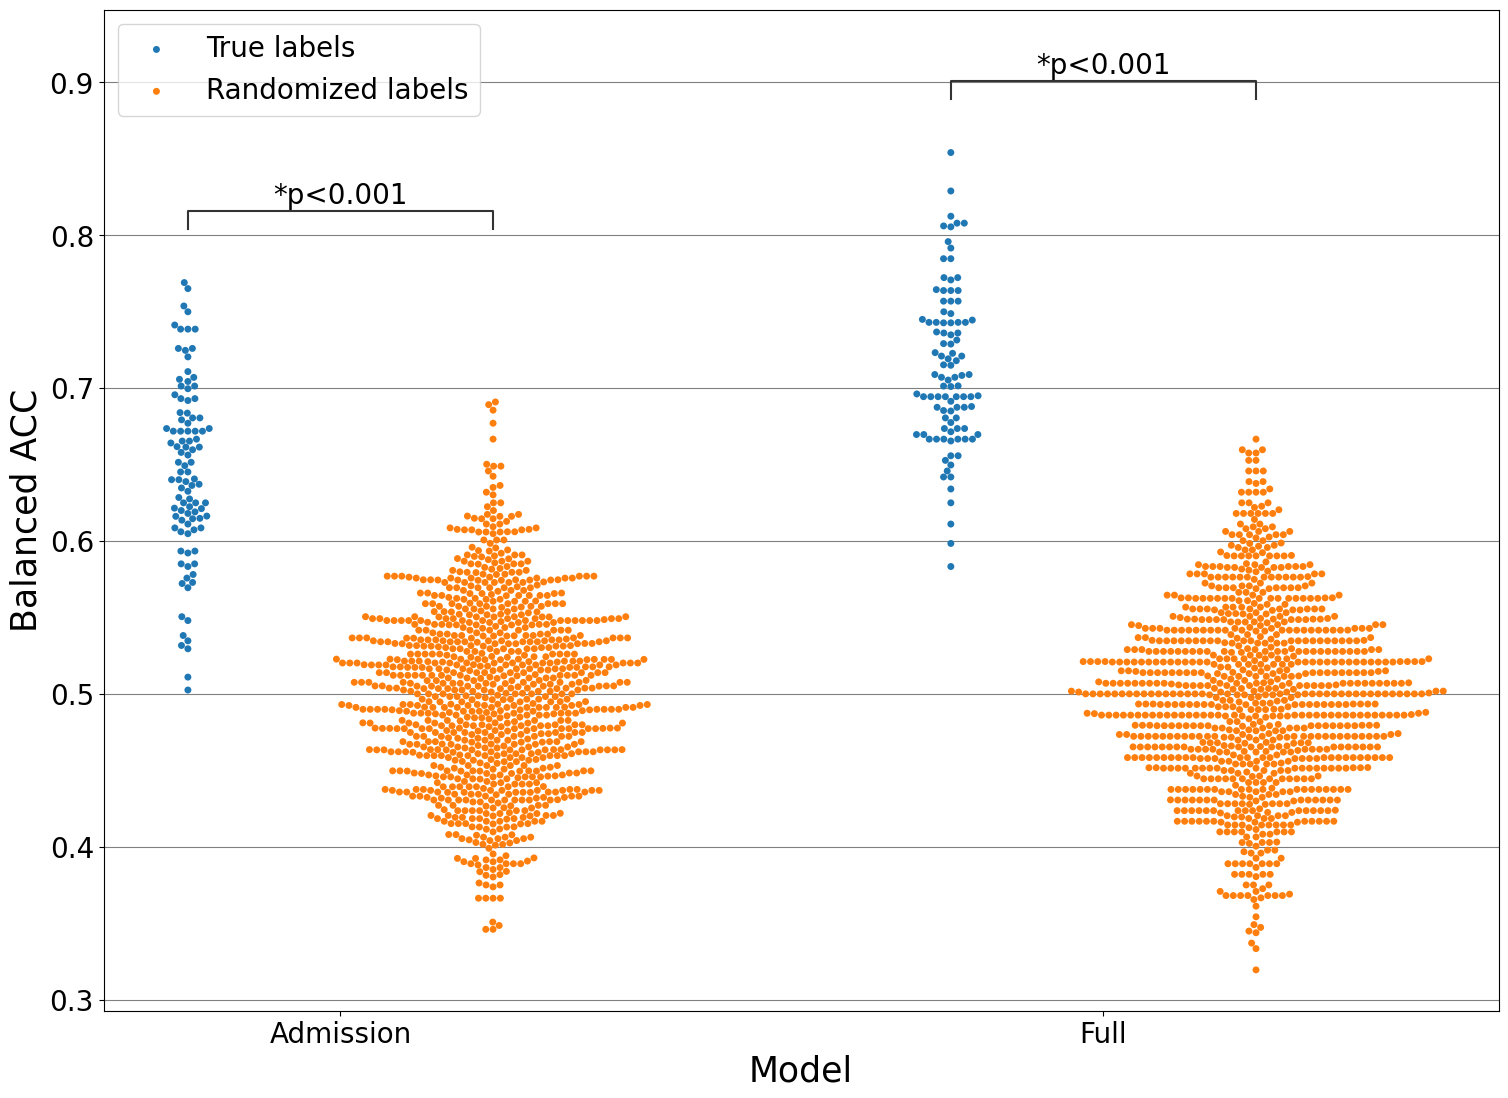

In [65]:
# Load OPTUNA DATA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"

results_24hs_permuted = pd.read_csv(results_dir + "Full_permutation_test.csv")
results_24hs_permuted  = results_24hs_permuted[results_24hs_permuted["Thresholds"]==0.5]
results_24hs_permuted  = results_24hs_permuted[results_24hs_permuted["Number of Removed Features"]==0]
results_24hs_permuted = results_24hs_permuted.drop_duplicates(subset=['Fold', "Random Permutation Number"], keep='first')


results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/full_model/"
results_full = pd.read_csv(results_dir + "Full_direct_remove.csv", index_col=0)
results_full = results_full[results_full["Thresholds"] == 0.5]
results_full = results_full[results_full["Number of Removed Features"] == 0]
results_full["Random State"] =  False

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/optuna/big_experiment/"
results_admission_permuted = pd.read_csv(results_dir + "Admission_permutation_test.csv")
results_admission_permuted  = results_admission_permuted[results_admission_permuted["Thresholds"]==0.5]

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/admission_model/"
results_admission = pd.read_csv(results_dir + "Admission_direct_remove.csv", index_col=0)

results_admission = results_admission[results_admission["Thresholds"] == 0.5]
results_admission = results_admission[results_admission["Number of Removed Features"] == 0]
results_admission["Random State"] =  False

models_to_plot = [
    "Admission",
    "Full", 
]

res = pd.concat([results_admission, results_admission_permuted, results_full,results_24hs_permuted])
metric_to_plot = "Balanced ACC"

fig, ax = plt.subplots(1, 1, figsize=[18, 13])

sns.swarmplot(
    data=res,
    x="Model", y=metric_to_plot,
    dodge=True, hue="Random State", ax=ax,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:models_to_plot.__len__()], labels[:models_to_plot.__len__()])
ax.legend(["True labels", "Randomized labels"])

# Comparisons for statistical test
box_list = [
            (("Admission", True), ("Admission", False)),

            (("Full", True), ("Full", False)),

            ]


add_stat_annotation(ax, data=res, x="Model", y=metric_to_plot,
                    box_pairs=box_list, test='Mann-Whitney', hue="Random State",
                    text_format='star', loc='inside',
                    verbose=1,
                    pvalue_thresholds=[[1, "ns"], [0.001, "*p<0.001"]])

plt.grid(alpha=0.5, axis="y", c="black")


# Missing value experiment Admission Model

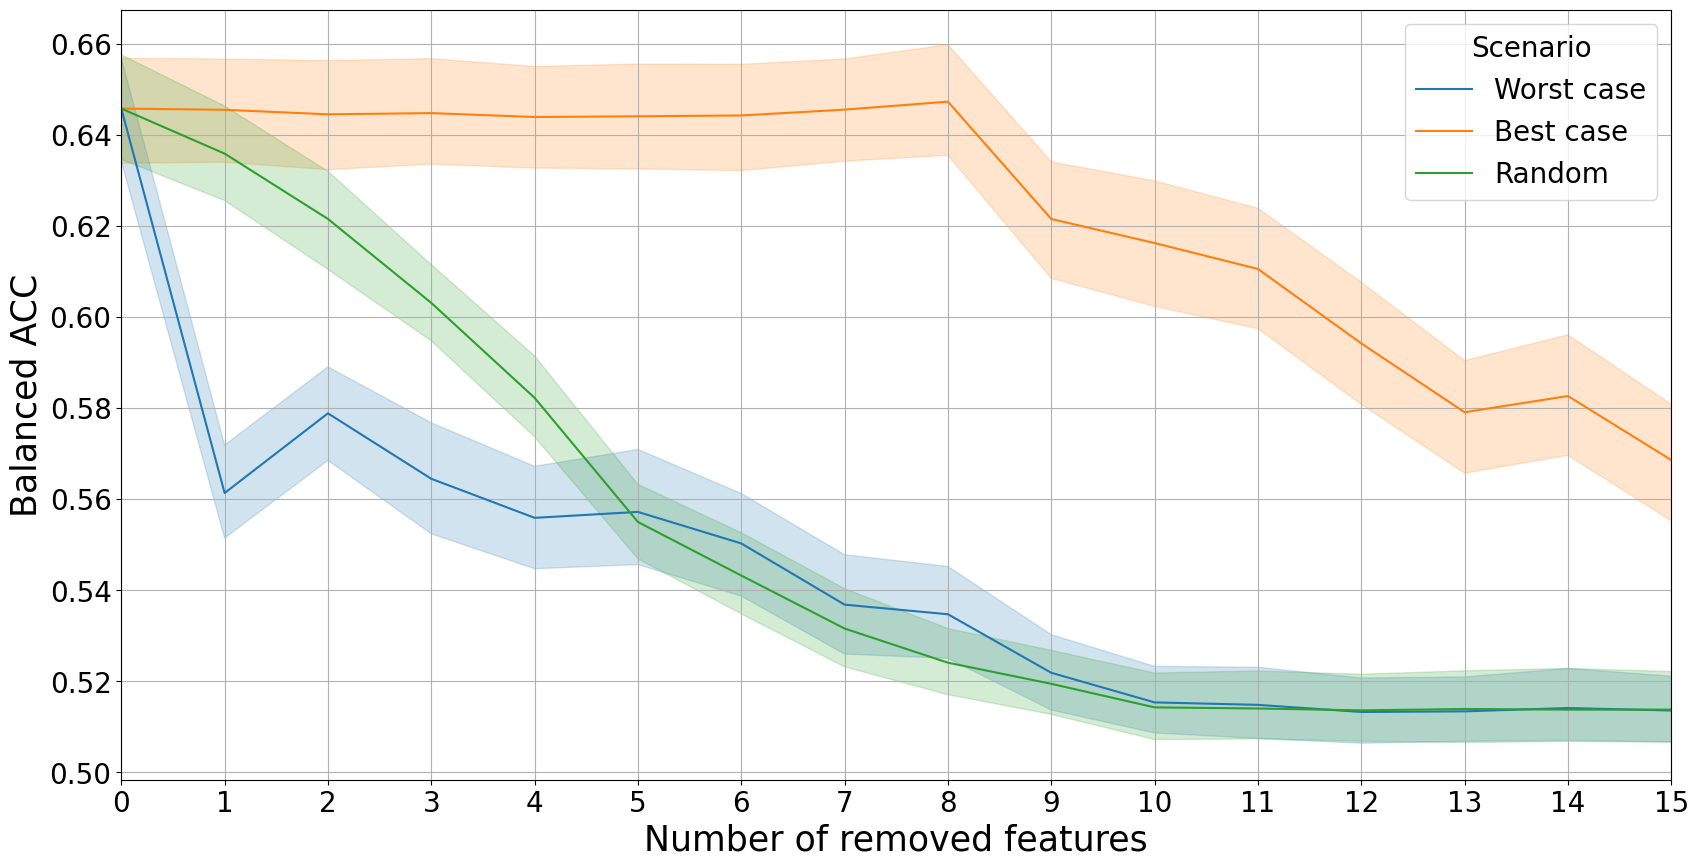

In [71]:

data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/admission_model/"

results_random = pd.read_csv(data_dir + "Admission_random_remove.csv", index_col=0)
results_random = results_random[results_random["Thresholds"] == 0.5]
results_random["Scenario"] = "Random"

results_direct = pd.read_csv(data_dir + "Admission_direct_remove.csv", index_col=0)
results_direct = results_direct[results_direct["Thresholds"] == 0.5]
results_direct["Scenario"] = "Worst case"

results_inverse = pd.read_csv(data_dir + "Admission_inverse_remove.csv", index_col=0)

results_inverse = results_inverse[results_inverse["Thresholds"] == 0.5]
results_inverse["Scenario"] = "Best case"


fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "Balanced ACC"
results_mv = pd.concat([results_direct,results_inverse,results_random])
results_mv_to_plot = results_mv[results_mv["Model"] == "Admission"]

sns.lineplot(
    data=results_mv_to_plot,
    x="Number of Removed Features", y=metric_to_plot,
    hue="Scenario", ax=ax
)
plt.grid()
plt.xlim(0,15)
plt.xlabel("Number of removed features")
custom_ticks = np.arange(0, 16, 1)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
# plt.title("Missing values impact in 24hs Model")
plt.show()

# Missing value experiment Full Model

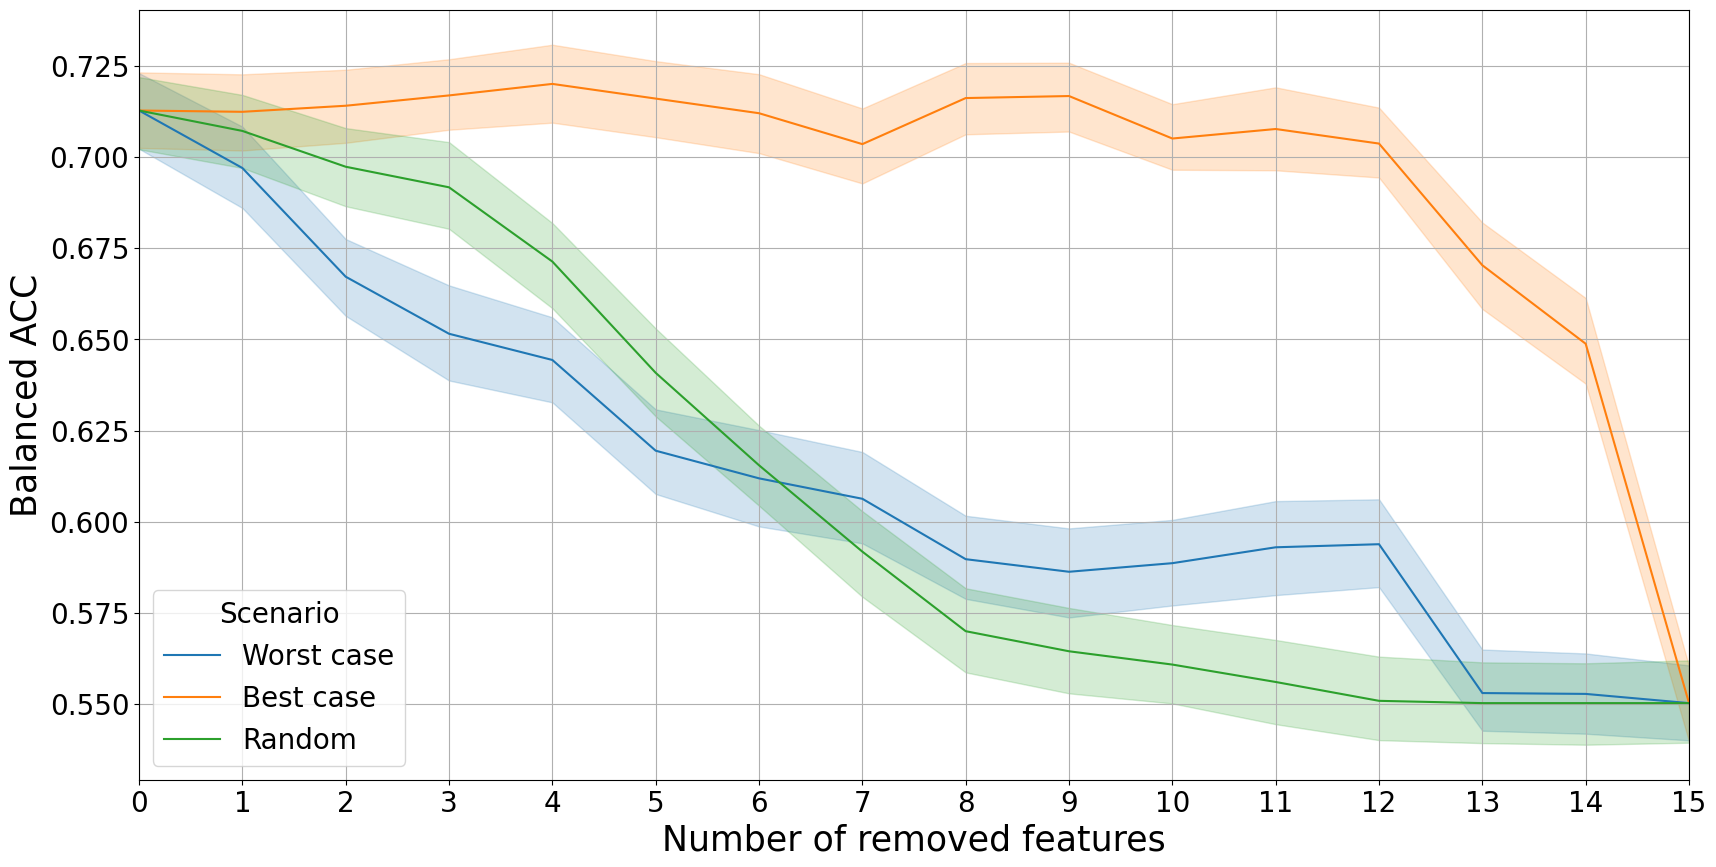

In [74]:

data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/full_model/"

results_random = pd.read_csv(data_dir + "Full_random_remove.csv", index_col=0)
results_random = results_random[results_random["Thresholds"] == 0.5]
results_random["Scenario"] = "Random"

results_direct = pd.read_csv(data_dir + "Full_direct_remove.csv", index_col=0)
results_direct = results_direct[results_direct["Thresholds"] == 0.5]
results_direct["Scenario"] = "Worst case"

results_inverse = pd.read_csv(data_dir + "Full_inverse_remove.csv", index_col=0)

results_inverse = results_inverse[results_inverse["Thresholds"] == 0.5]
results_inverse["Scenario"] = "Best case"


fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "Balanced ACC"
results_mv = pd.concat([results_direct,results_inverse,results_random])
results_mv_to_plot = results_mv[results_mv["Model"] == "Full"]

sns.lineplot(
    data=results_mv_to_plot,
    x="Number of Removed Features", y=metric_to_plot,
    hue="Scenario", ax=ax
)
plt.grid()
plt.xlim(0,15)
plt.xlabel("Number of removed features")
custom_ticks = np.arange(0, 16, 1)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
# plt.title("Missing values impact in 24hs Model")
plt.show()

# CordShock Score 

In [6]:
results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/CardSchock/"       # noqa

results_CardShock = pd.read_csv(results_dir + "CardShock.csv", index_col=0)
results_CardShock = results_CardShock[results_CardShock["Number of Removed Features"] == 0]
results_CardShock = results_CardShock[results_CardShock["Thresholds"] == 0.5]
results_CardShock.drop(columns=['Fold', 'Random State', 'Random Permutation Number',
       'Thresholds', 'Number of Removed Features', "Recall"], inplace=True)

results_true_label = pd.concat([results_CardShock])


models_to_plot = [
                  "CardShock_Score_test",
                  ]

metrics = ["Balanced ACC",
           "AUC",
           "F1",
           "Specificity",
           "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(results_true_label[results_true_label["Model"] == model][metric].mean(),3)
        results_std = round(results_true_label[results_true_label["Model"] == model][metric].std(),3)
        confidence_interval = stats.t.interval(0.95, len(results_true_label[results_true_label["Model"] == model][metric]) - 1, loc=results_mean, scale=results_std)

        print(metric + ": " + str(results_mean) + " ["+str(round(confidence_interval[0],3)) + "/" + str(round(confidence_interval[1],3))+"]")


CardShock_Score_test
Balanced ACC: 0.567 [0.373/0.761]
AUC: 0.694 [0.418/0.97]
F1: 0.341 [-0.115/0.797]
Specificity: 0.807 [0.454/1.16]
Sensitivity: 0.328 [-0.196/0.852]


# Admission model performance on eICU dataset

In [13]:

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/eICU/admission_model/"       # noqa

results_admission = pd.read_csv(results_dir + "Admission_performance_CULPRIT_eICU.csv", index_col=0)
results_admission = results_admission[results_admission["Number of Removed Features"] == 0]
results_admission = results_admission[results_admission["Thresholds"] == 0.5]
results_admission.drop(columns=['Fold', 'Random State', 'Random Permutation Number',
       'Thresholds', 'Number of Removed Features', "Recall"], inplace=True)

results_true_label = pd.concat([results_admission])


models_to_plot = [
                  "Admission Train (CULPRIT)",
                  "Admission Test (eICU)"
                  ]

metrics = ["Balanced ACC",
           "AUC",
           "F1",
           "Specificity",
           "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(results_true_label[results_true_label["Model"] == model][metric].mean(),3)
        results_std = round(results_true_label[results_true_label["Model"] == model][metric].std(),3)

        print(metric + ": " + str(results_mean))


Admission Train (CULPRIT)
Balanced ACC: 0.712
AUC: 0.8
F1: 0.687
Specificity: 0.762
Sensitivity: 0.662
Admission Test (eICU)
Balanced ACC: 0.605
AUC: 0.63
F1: 0.523
Specificity: 0.678
Sensitivity: 0.531


# Full model performance on eICU dataset

In [30]:

results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/eICU/full_model/"       # noqa

results = pd.read_csv(results_dir + "Full_performance_CULPRIT_eICU.csv", index_col=0)
results.drop(columns=['Fold', 'Random State', 'Random Permutation Number',
       'Thresholds', 'Number of Removed Features', "Recall"], inplace=True)

results_true_label = pd.concat([results])


models_to_plot = [
                  "Full Train (CULPRIT)",
                  "Full test (eICU)"
                  ]

metrics = ["Balanced ACC",
           "AUC",
           "F1",
           "Specificity",
           "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(results_true_label[results_true_label["Model"] == model][metric].mean(),3)
        results_std = round(results_true_label[results_true_label["Model"] == model][metric].std(),3)

        print(metric + ": " + str(results_mean))


Full Train (CULPRIT)
Balanced ACC: 0.892
AUC: 0.952
F1: 0.872
Specificity: 0.942
Sensitivity: 0.843
Full test (eICU)
Balanced ACC: 0.636
AUC: 0.769
F1: 0.493
Specificity: 0.886
Sensitivity: 0.385


# LG Admission performance

In [8]:
results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/LG_compare/LG_with_scaler/"       # noqa

results = pd.read_csv(results_dir + "LG_complete_data_admission.csv", index_col=0)
results = results[results["Model"] == "LG_complete_admission_test"]
results = results[results["Number of Removed Features"] == 0]
results = results[results["Thresholds"] == 0.5]
results.drop(columns=['Fold', 'Random State', 'Random Permutation Number',
       'Thresholds', 'Number of Removed Features', "Recall"], inplace=True)

results_true_label = pd.concat([results])


models_to_plot = [
                  "LG_complete_admission_test",
                  ]

metrics = ["Balanced ACC",
           "AUC",
           "F1",
           "Specificity",
           "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(results_true_label[results_true_label["Model"] == model][metric].mean(),3)
        results_std = round(results_true_label[results_true_label["Model"] == model][metric].std(),3)
        confidence_interval = stats.t.interval(0.95, len(results_true_label[results_true_label["Model"] == model][metric]) - 1, loc=results_mean, scale=results_std)

        print(metric + ": " + str(results_mean) + " ["+str(round(confidence_interval[0],3)) + "/" + str(round(confidence_interval[1],3))+"]")


LG_complete_admission_test
Balanced ACC: 0.669 [0.554/0.784]
AUC: 0.734 [0.615/0.853]
F1: 0.624 [0.487/0.761]
Specificity: 0.737 [0.562/0.912]
Sensitivity: 0.601 [0.418/0.784]


# Shap Admission

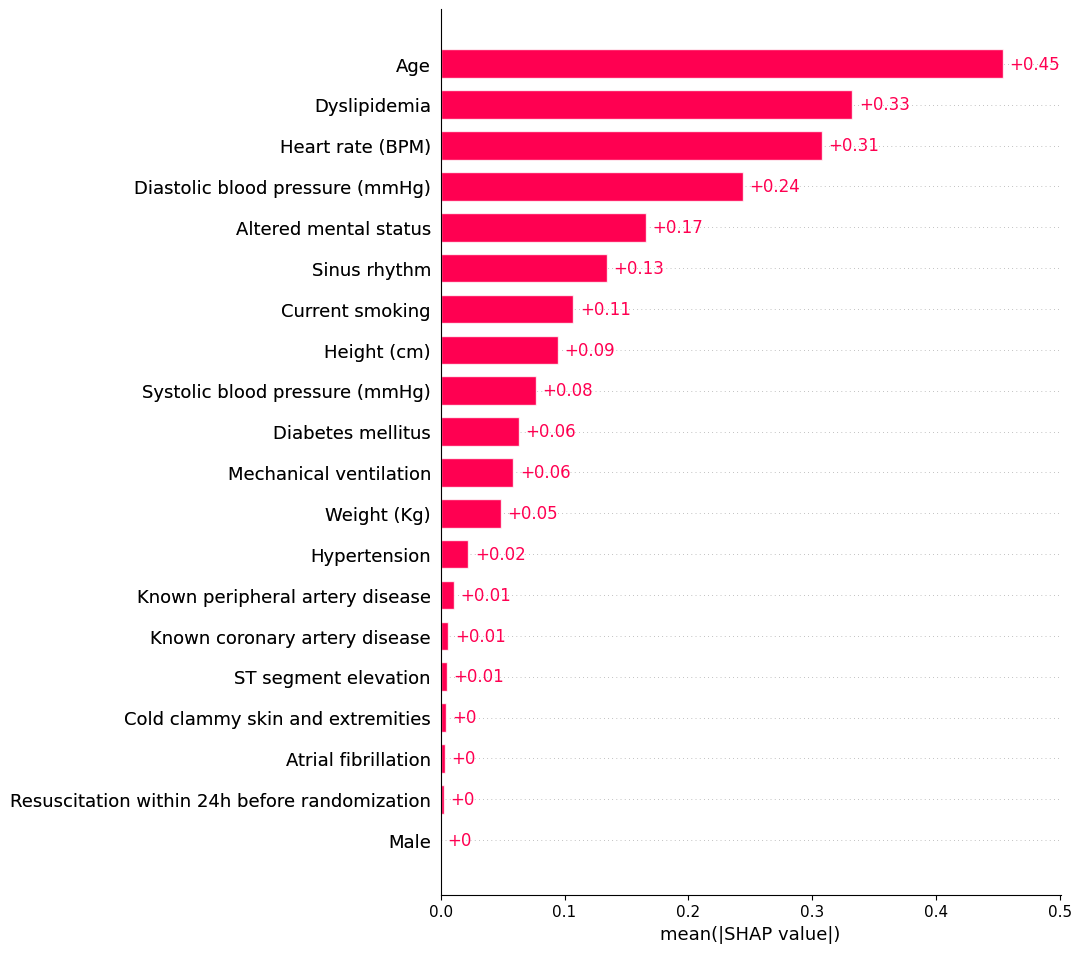

In [220]:

data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/admission_model/shap/"
load_list = ["shap_values_Admission",
             "shap_baselineAdmission",
             "shap_dataAdmission"]
shap_dict = dict()

for file_name in load_list:
    with open(data_dir+file_name, "rb") as fp:
        shap_dict[file_name] = pickle.load(fp)
X_admission = pd.read_csv(data_dir+"X_Admission.csv",index_col=0)
Y_admission = pd.read_csv(data_dir+"Y_Admission.csv",index_col=0)
pred = pd.read_csv(data_dir+"predictions_Admission_shap.csv",index_col=0)

X_admission.rename(columns={"Age_(year)": "Age",
                            "Heart_rate_(bpm)_Hemodinamics": "Heart rate (BPM)",
                            "Diastolic_blood_pressure_(mmHg)_–_HPR":"Diastolic blood pressure (mmHg)",
                            "Height_(cm)": "Height (cm)",
                            "Weight_(kg)": "Weight (Kg)",
                            'Mechanical_ventilation':'Mechanical ventilation',
                            "Resuscitation_within_24h_before_randomization": "Resuscitation within 24h before randomization",
                            "Altered_mental_status": "Altered mental status",
                            "Cold_clammy_skin_and_extremities": "Cold clammy skin and extremities",
                            "previous_heart_complications": "Known coronary artery disease",
                            "Previous_congestive_heart_failure": "Previous congestive heart failure",
                            "Previous_stroke": "Previous stroke",
                            "Known_peripheral_artery_disease": "Known peripheral artery disease",
                            "Known_renal_insufficiency_(GFR_less_30_ml/min)": "Known renal insufficiency",
                            "Chronic_dialysis":"Chronic dialysis",
                            "Current_smoking": "Current smoking",
                            "Diabetes_mellitus": "Diabetes mellitus",
                            "Sinus_rhythm": "Sinus rhythm",
                            "Atrial_fibrillation": "Atrial fibrillation",
                            "AV-block_III": "AV block III",
                            'ST-segment_elevation':'ST segment elevation',
                            'Systolic_blood_pressure_(mmHg)_–_HPR':'Systolic blood pressure (mmHg)'}, inplace=True)


model = joblib.load(data_dir+"model_Admission_shap_values.pkl")

explainer = shap.Explainer(model)
shap_values = explainer(X_admission)

plt.figure(figsize=[15,10])
shap_values.values = shap_dict["shap_values_Admission"]
shap_values.baseline = shap_dict["shap_baselineAdmission"]
shap_values.data = shap_dict["shap_dataAdmission"]
shap.plots.bar(shap_values, max_display=28)

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

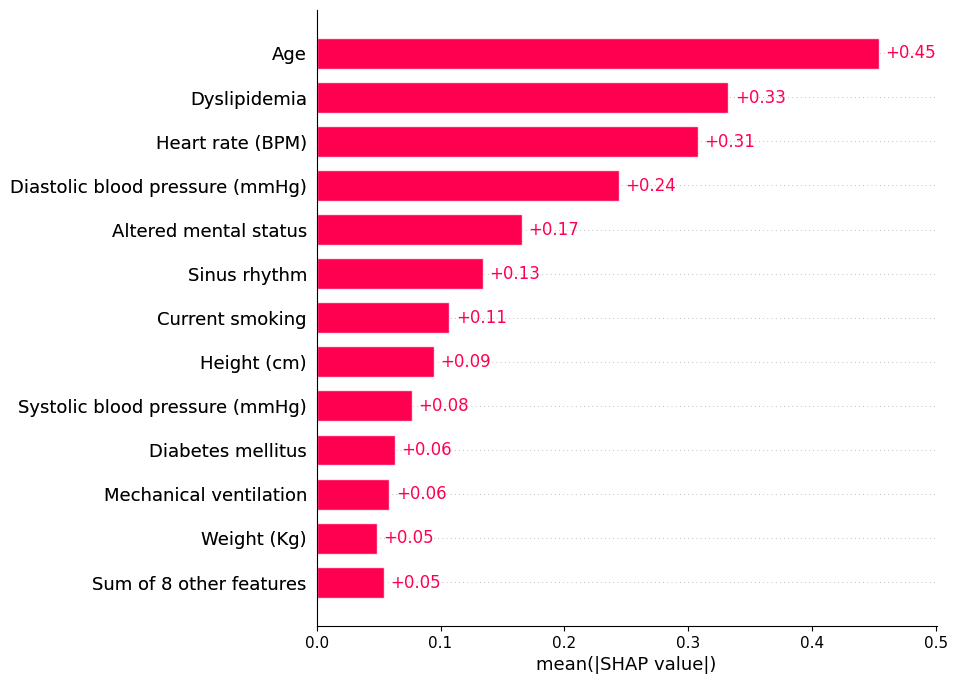

In [173]:
shap.plots.bar(shap_values, max_display=13)


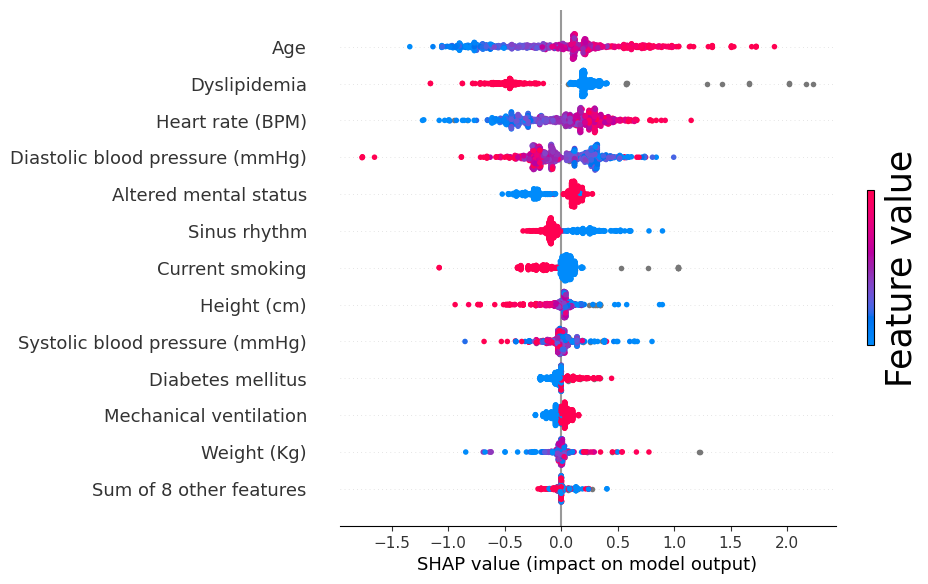

In [180]:
shap.plots.beeswarm(shap_values, color_bar=False, max_display=13,show=False)
plt.colorbar(location="right",label="Feature value", ticks=[], shrink=0.3)

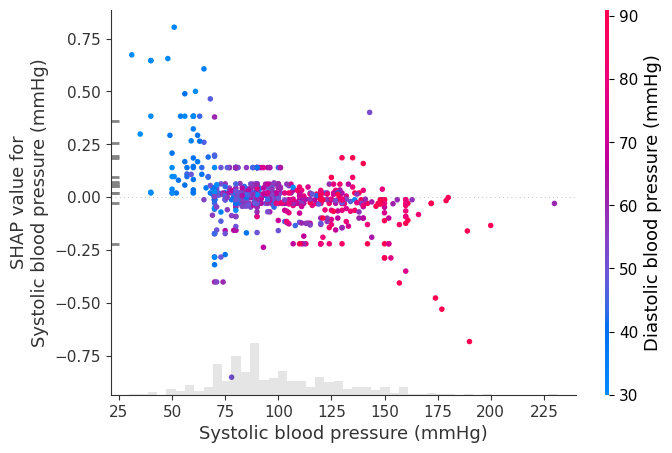

In [199]:
shap.plots.scatter(shap_values[:, "Systolic blood pressure (mmHg)"], color=shap_values[:, "Diastolic blood pressure (mmHg)"], show=False)


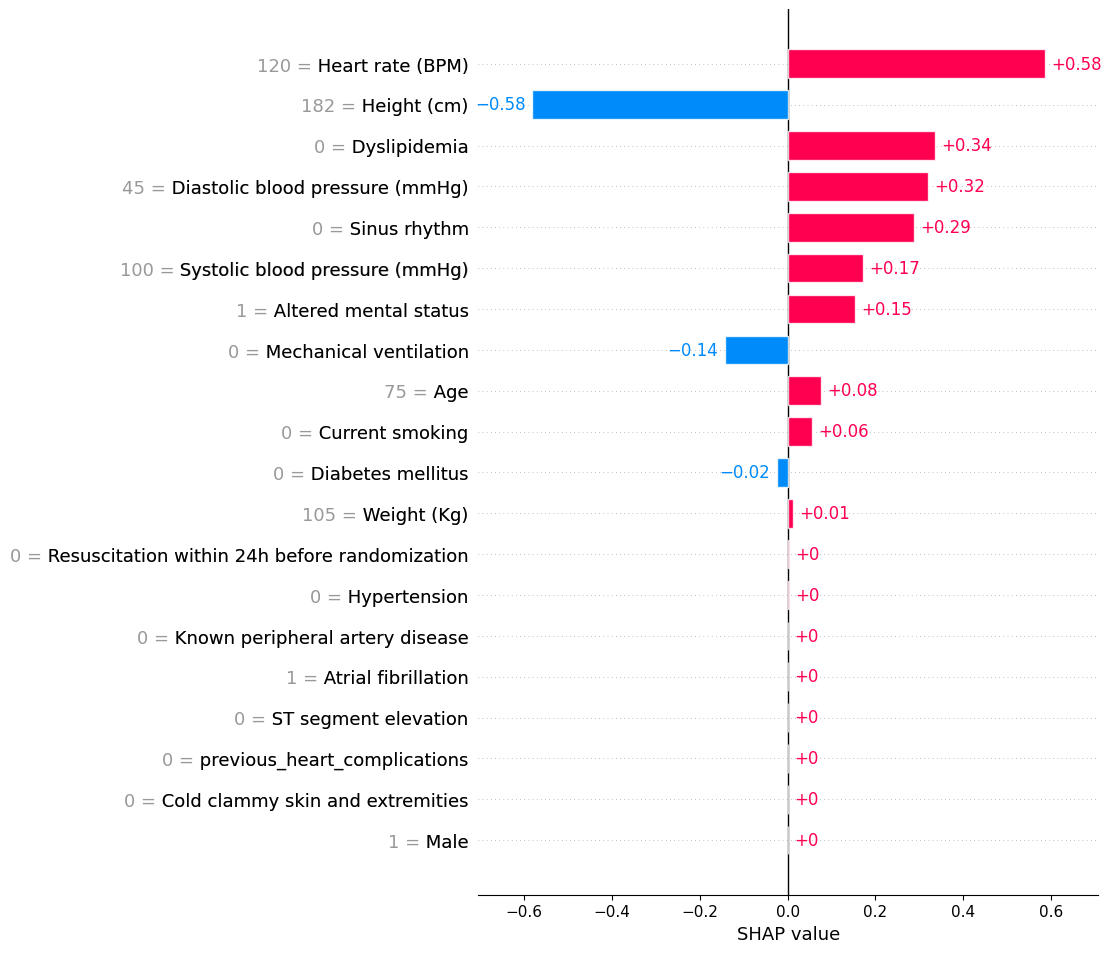

In [9]:
shap.plots.bar(shap_values[67], max_display=89)


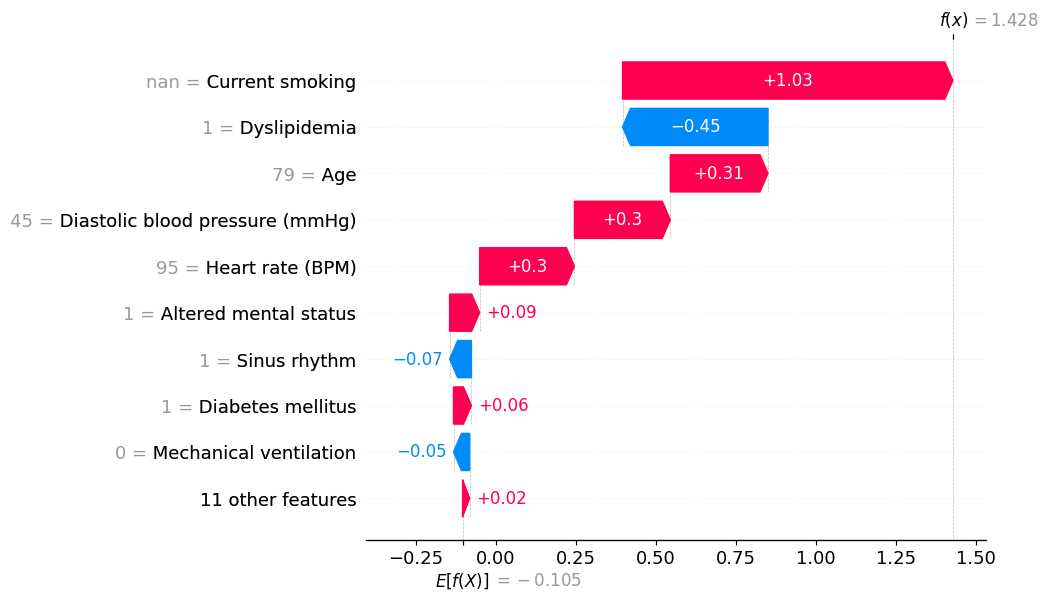

In [115]:
shap.plots.waterfall(shap_values[122])


/home/nnieto/Nico/MODS_project/Heart_env/lib/python3.9/site-packages/shap/utils/_clustering.py:126: UserWarning: No/low signal found from feature 4 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
  warnings.warn(f"No/low signal found from feature {i} (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).")
/home/nnieto/Nico/MODS_project/Heart_env/lib/python3.9/site-packages/shap/utils/_clustering.py:126: UserWarning: No/low signal found from feature 19 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
  warnings.warn(f"No/low signal found from feature {i} (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).")


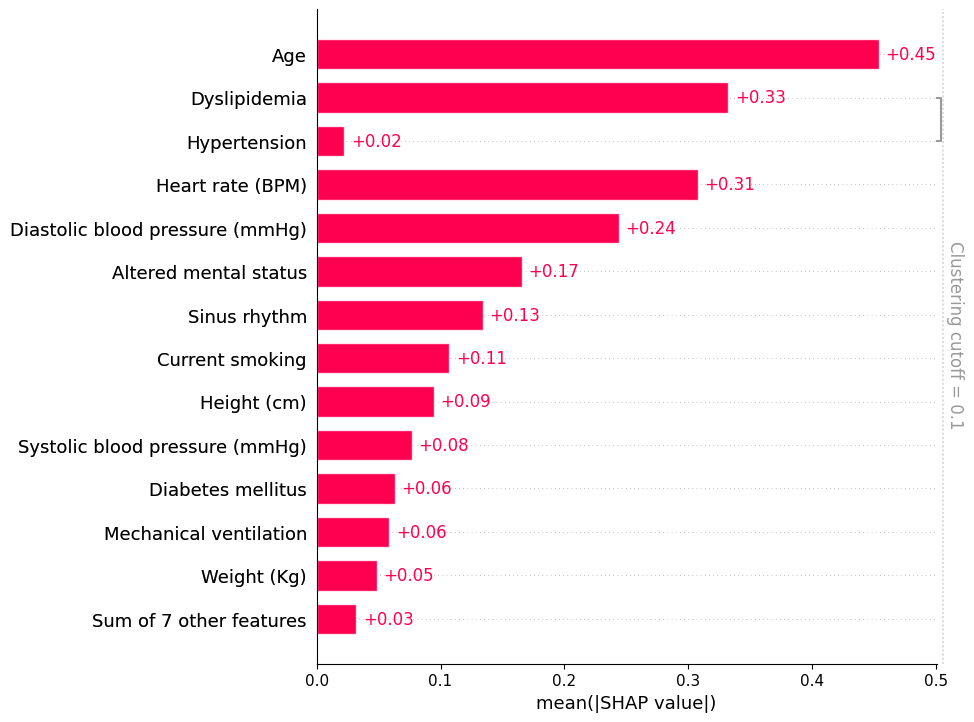

In [175]:
clustering = shap.utils.hclust(X_admission, Y_admission)
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.1,  max_display=14)

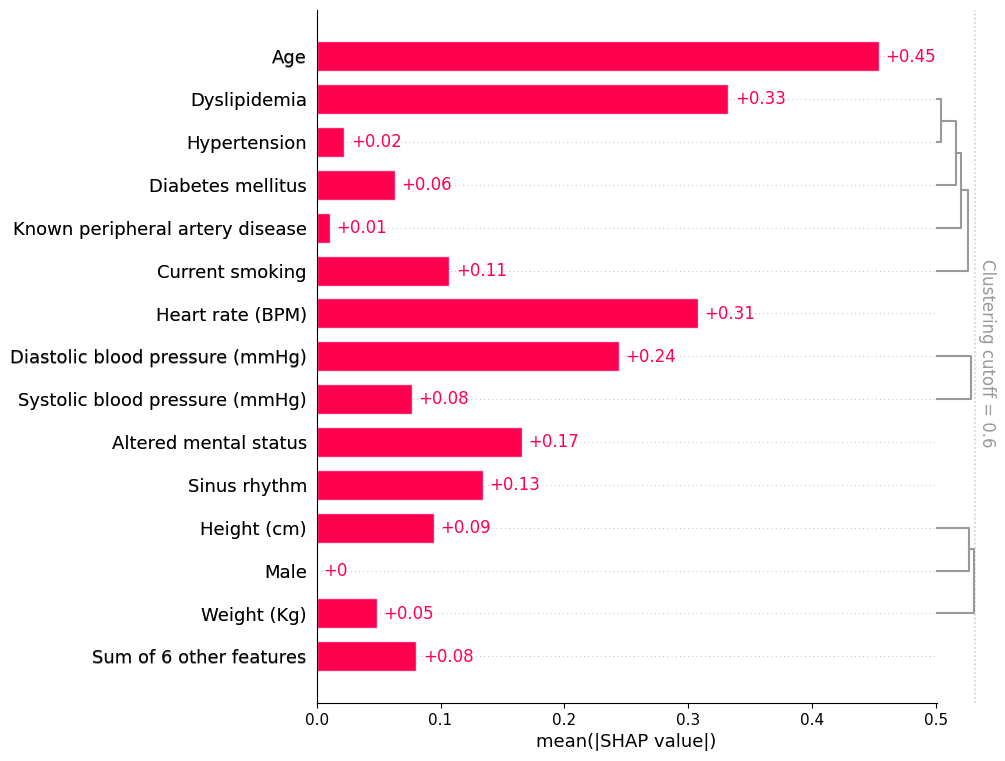

In [177]:

shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.6,  max_display=15)

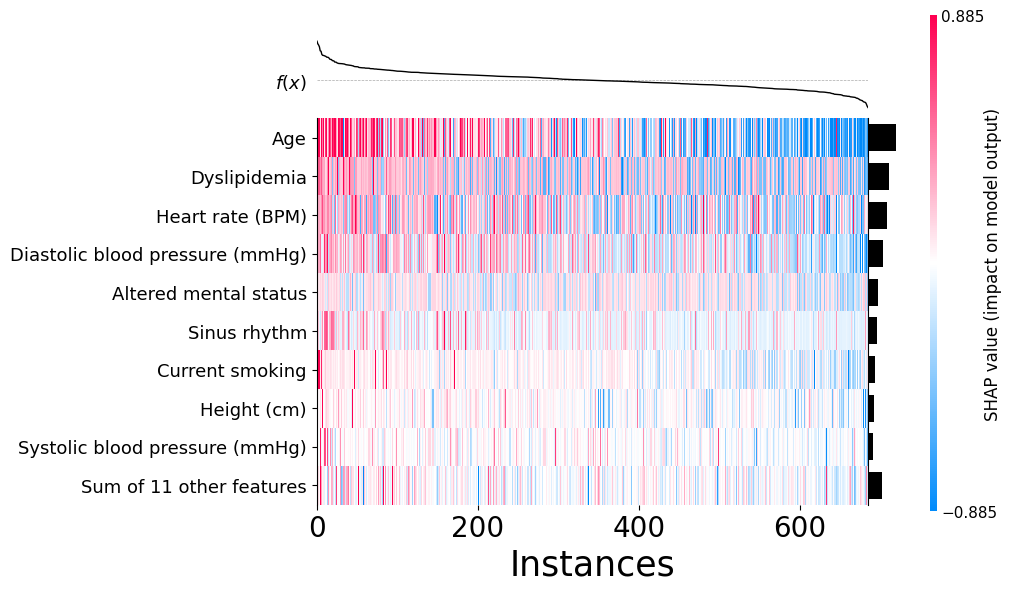

<AxesSubplot: xlabel='Instances'>

In [222]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

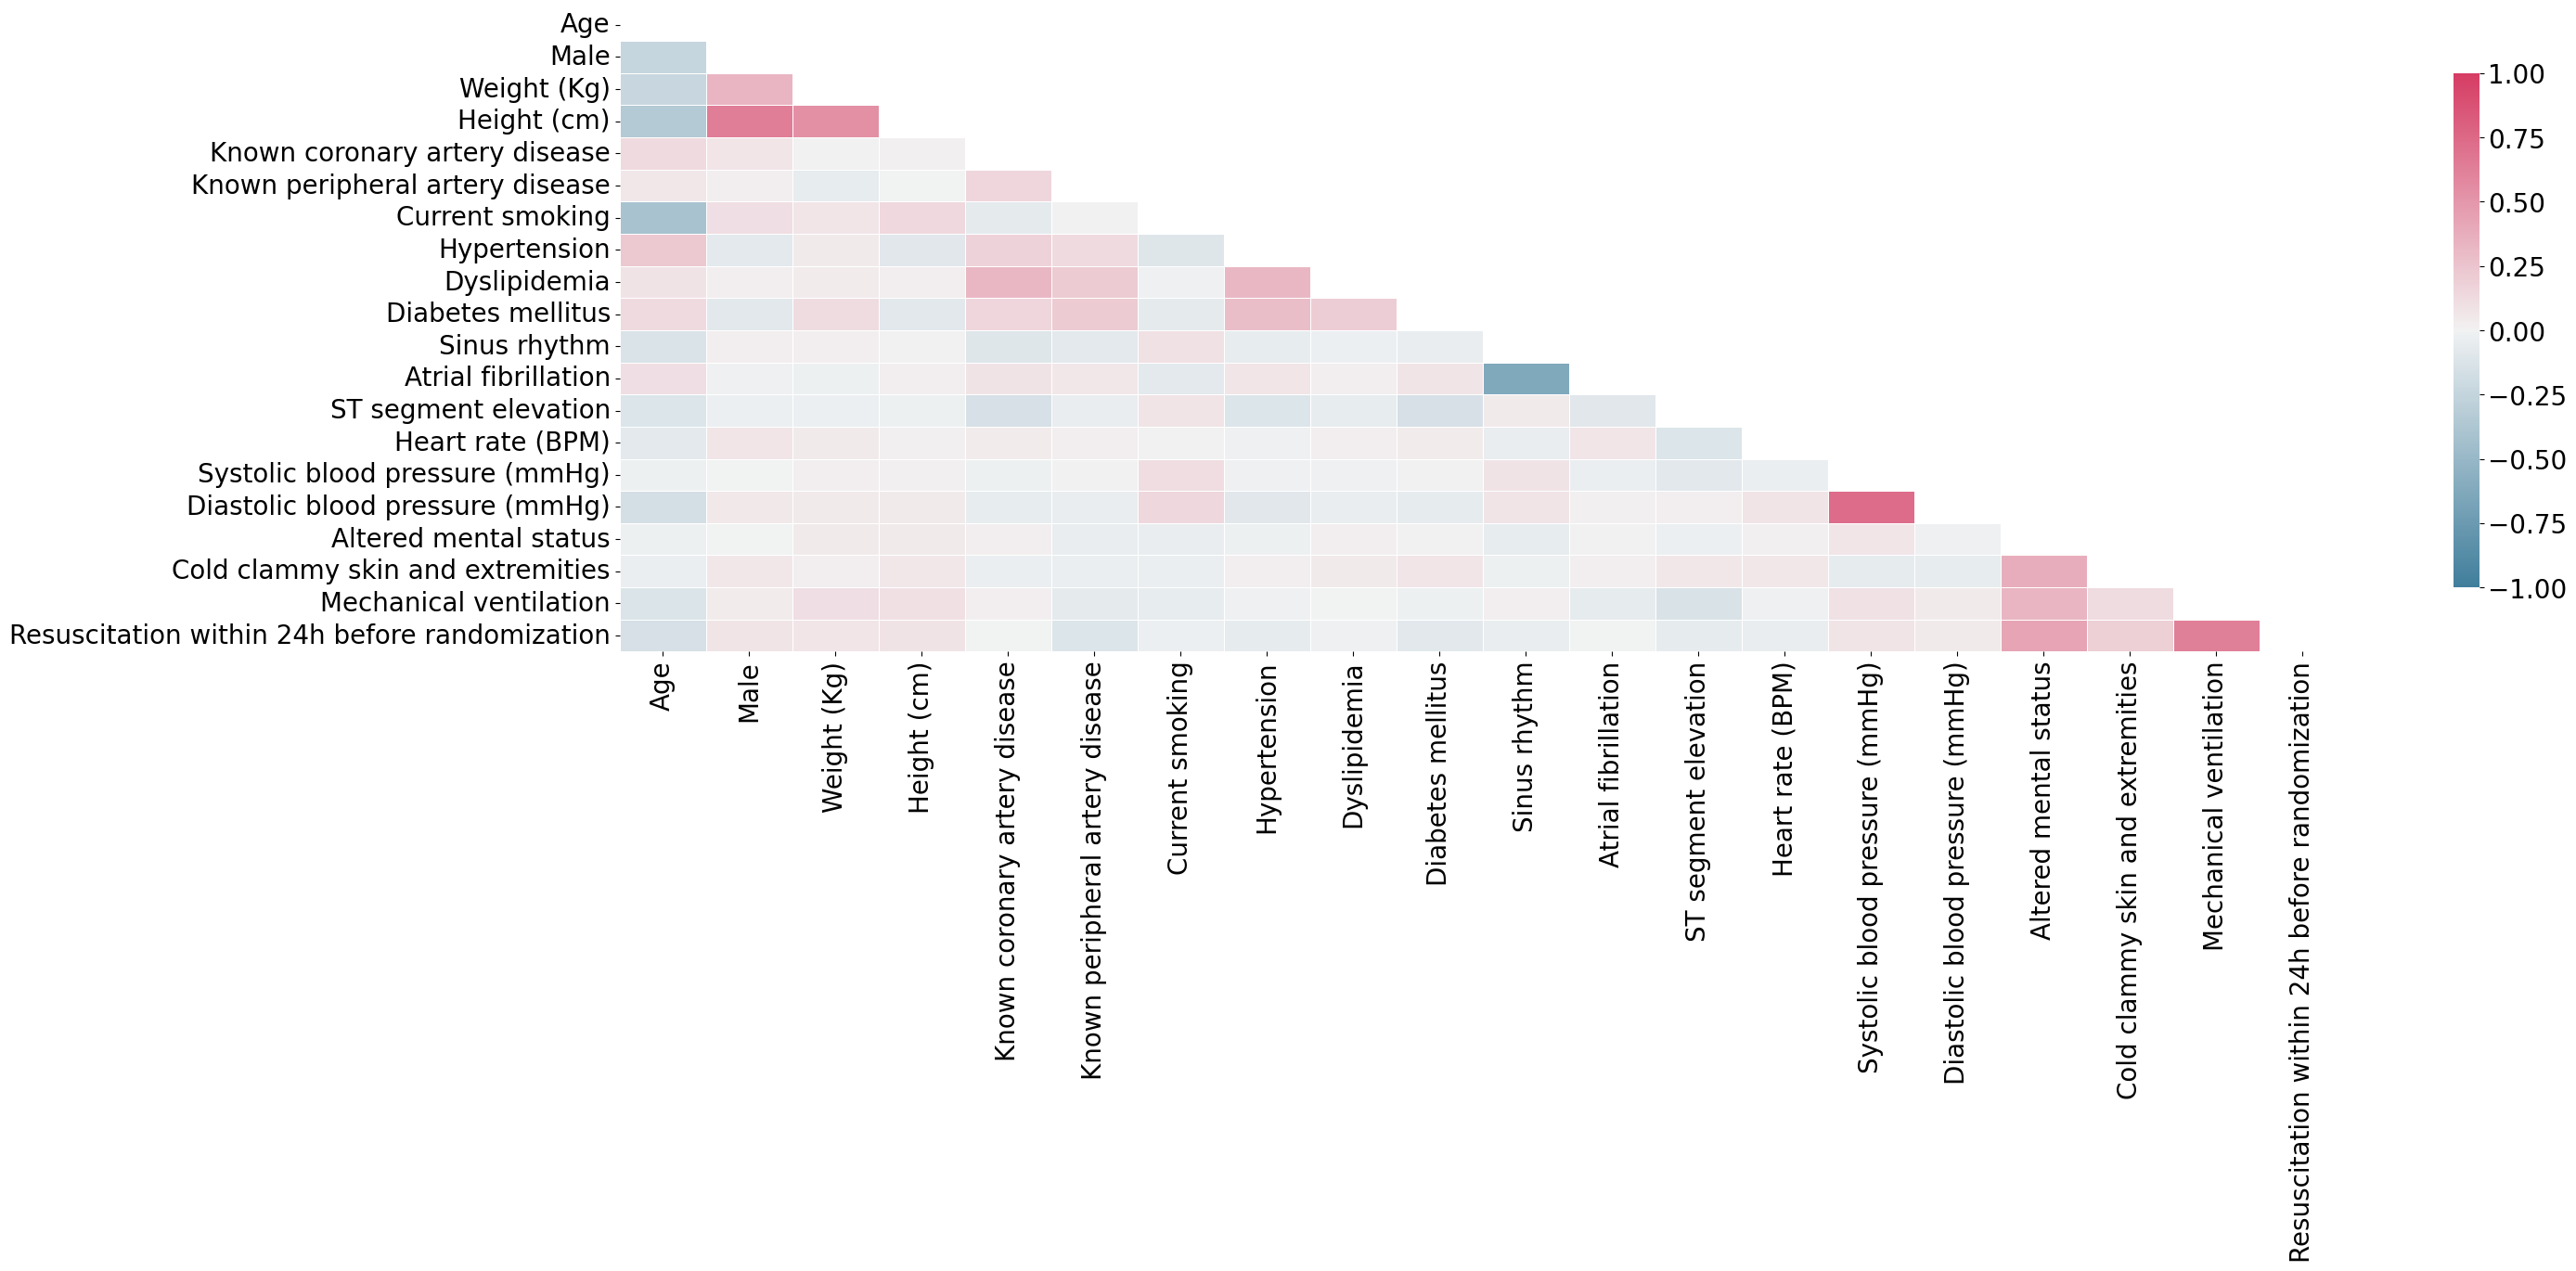

In [243]:
X_admission_2 = X_admission.copy()
X_admission_2["Male"] = Y_admission
corr = X_admission.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 9))
# Generate a diverging colormap
cmap = sns.diverging_palette(230, 2, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
square=False, linewidths=.5, cbar_kws={"shrink": .8}, annot=False, fmt=".1f")
plt.show()

# Shap on Full model

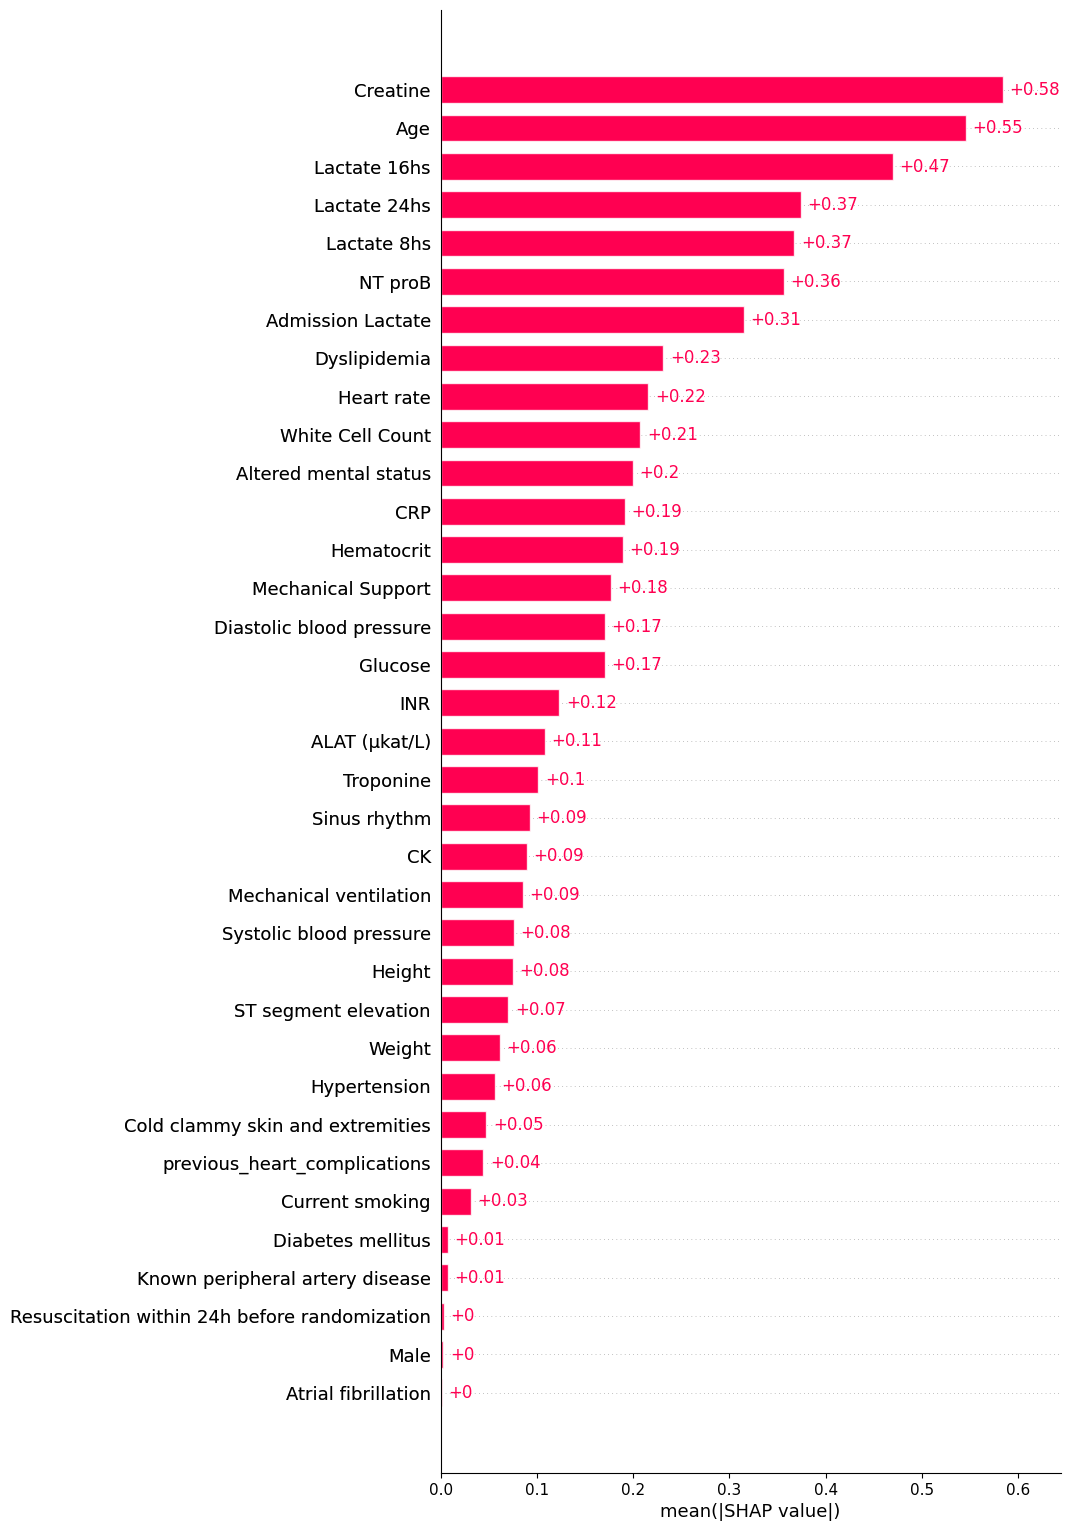

In [203]:
data_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/full_model/shap/"
load_list = ["shap_24hs_values",
             "shap_24hs_baseline",
             "shap_24hs_data"]
shap_dict = dict()

for file_name in load_list:
    with open(data_dir+file_name, "rb") as fp:
        shap_dict[file_name] = pickle.load(fp)
X_24 = pd.read_csv(data_dir+"X_24hs_v2.csv",index_col=0)
y_24 = pd.read_csv(data_dir+"Y_24hs.csv",index_col=0) 

X_24.rename(columns={"Age_(year)": "Age",
                    "Heart_rate_(bpm)_Hemodinamics": "Heart rate",
                    "Diastolic_blood_pressure_(mmHg)_–_HPR":"Diastolic blood pressure",
                    "Height_(cm)": "Height",
                    "Weight_(kg)": "Weight",
                    'Mechanical_ventilation':'Mechanical ventilation',
                    "Resuscitation_within_24h_before_randomization": "Resuscitation within 24h before randomization",
                    "Altered_mental_status": "Altered mental status",
                    "Cold_clammy_skin_and_extremities": "Cold clammy skin and extremities",
                    "combined_variable": "Combined variable",
                    "Previous_congestive_heart_failure": "Previous congestive heart failure",
                    "Previous_stroke": "Previous stroke",
                    "Known_peripheral_artery_disease": "Known peripheral artery disease",
                    "Known_renal_insufficiency_(GFR_less_30_ml/min)": "Known renal insufficiency",
                    "Chronic_dialysis":"Chronic dialysis",
                    "Current_smoking": "Current smoking",
                    "Diabetes_mellitus": "Diabetes mellitus",
                    "Sinus_rhythm": "Sinus rhythm",
                    "Atrial_fibrillation": "Atrial fibrillation",
                    "AV-block_III": "AV block III",
                    'ST-segment_elevation':'ST segment elevation',
                    'Systolic_blood_pressure_(mmHg)_–_HPR':'Systolic blood pressure',
                    "Mechanical_Support":"Mechanical Support",
                    "Mild_induced_Hypothermia":"Mild induced Hypothermia",
                    "Renal_Replacement_Therapy":"Renal Replacement Therapy",
                    "Pre_PCI_Serum_lactate_value": "Pre PCI Lactate",
                    "Post_PCI_Serum_lactate_value": "Post PCI Lactate",
                    "Serum_lactate_value_8": "Lactate 8hs",
                    "Serum_lactate_value_16": "Lactate 16hs",
                    "Serum_lactate_value_24": "Lactate 24hs",
                    "No_reflow": "No reflow",
                    "Hematocrit_in_%": "Hematocrit",
                    "White_blood_cell_count_in_Gpt/L": "White blood cell count",
                    "HS_Troponin_I": "HS Troponin I",
                    "Procedural_success_(TIMI3_or_successful_complete_revascularization)": "Procedural success",
                    "ALAT_in_µkat/l": "ALAT (µkat/L)",
                    "GFR_CKD-EPI_creatinine_equation_V1_in_ml/min/1.73m²": "GFR Creatinine",
                    "NT_pro_B-type_natriuretic_peptide_V1_in_pg/ml": "NT proB",
                    "creatine": "Creatine",
                    "admission_lactate": "Admission Lactate",
                    "hematocrit": "Hematocrit",
                    "glucose": "Glucose",
                    "white_cell_count": "White Cell Count",
                    "resusitation_24hs": "Resucitation within 24hs",
                    "hs-Troponine_T_V1_in_pg/ml": "Troponine",
                    "C_Reaktive_Protein_V1_in_mg/l": "CRP",
                    "ALAT [µkat/L]": "ALAT"}, inplace=True)


model = joblib.load(data_dir+"model_24hs_v2_shap_values.pkl")

explainer = shap.Explainer(model)
shap_values = explainer(X_24)

shap_values.values = shap_dict["shap_24hs_values"]
shap_values.baseline = shap_dict["shap_24hs_baseline"]
shap_values.data = shap_dict["shap_24hs_data"]
shap.plots.bar(shap_values, max_display=50)


/home/nnieto/Nico/MODS_project/Heart_env/lib/python3.9/site-packages/shap/utils/_clustering.py:126: UserWarning: No/low signal found from feature 4 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
  warnings.warn(f"No/low signal found from feature {i} (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).")
/home/nnieto/Nico/MODS_project/Heart_env/lib/python3.9/site-packages/shap/utils/_clustering.py:126: UserWarning: No/low signal found from feature 7 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
  warnings.warn(f"No/low signal found from feature {i} (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).")
36it [00:22,  1.03s/it

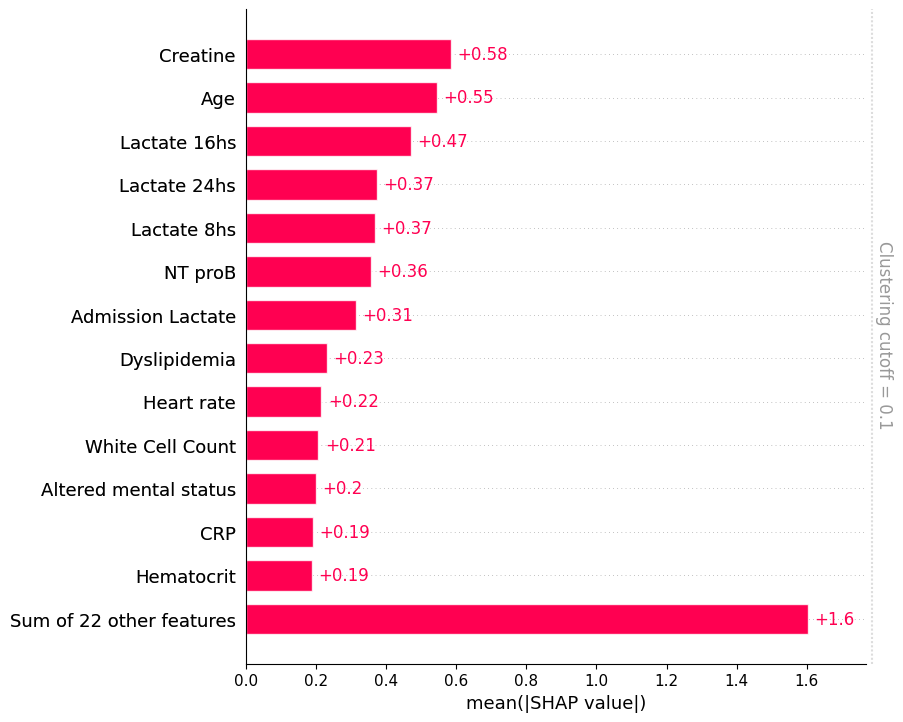

In [204]:
clustering = shap.utils.hclust(X_24, y_24)


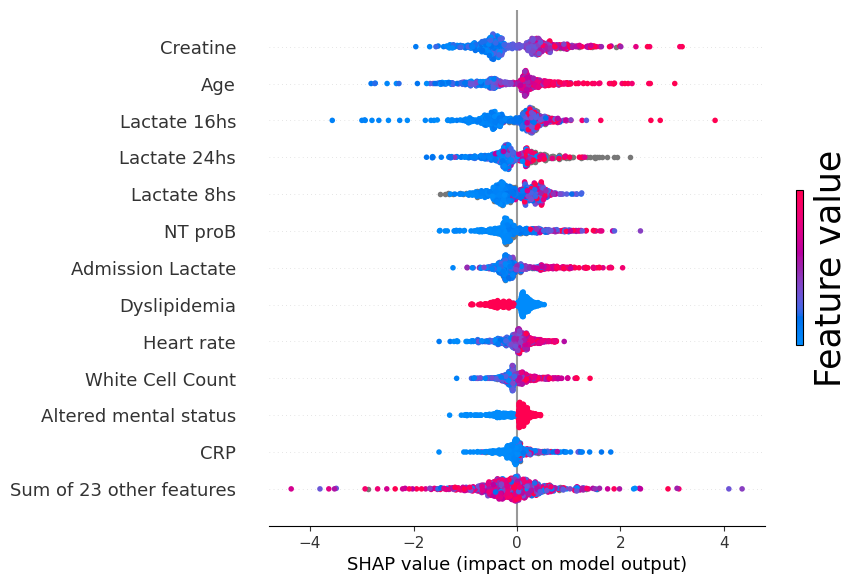

In [210]:
shap.plots.beeswarm(shap_values, color_bar=False, max_display=13,show=False)
plt.colorbar(location="right",label="Feature value", ticks=[], shrink=0.3)

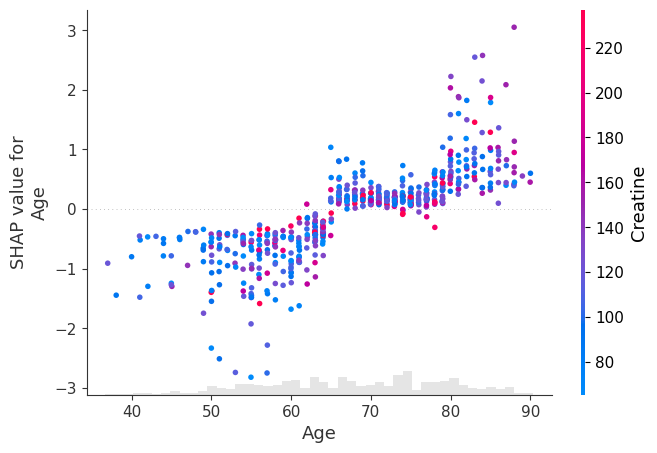

In [218]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values[:, "Creatine"], show=False)


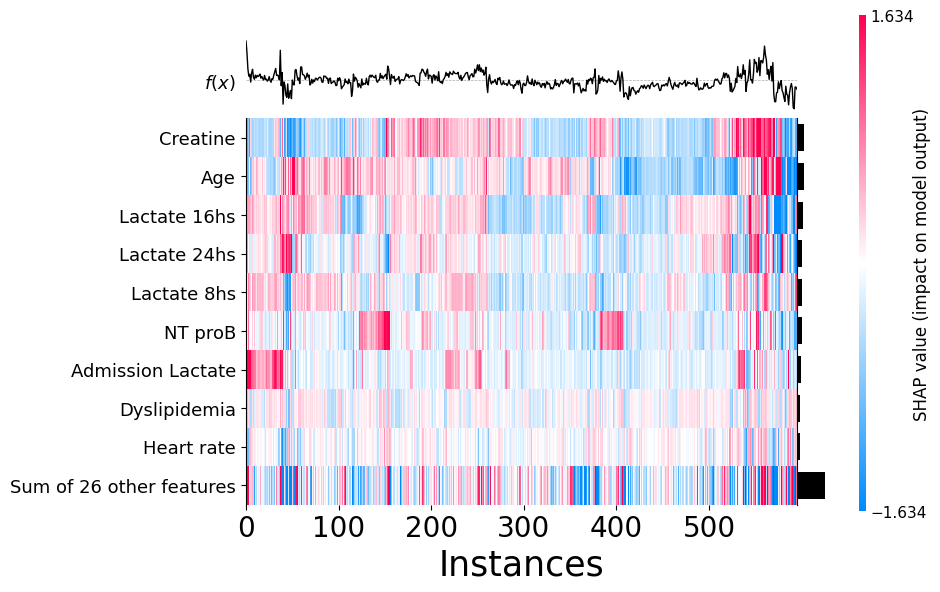

<AxesSubplot: xlabel='Instances'>

In [219]:
shap.plots.heatmap(shap_values)